In [1]:
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
import numpy as np
import heapq

Graph example:

nodes : List[int] where members are coordinates in order x,y...

connections : List[List[tuple[int, float]]] where List[i] contains i's neighbors

connection: (dest: int, weight: int) 

branch: (cost: int, nodeId: int)

node: List[int] where node[-1] is the heuristic 

# Graph plotter

In [2]:
def plotPoints(nodes: list[list[int]], connections: list[list[tuple[int, int]]], image, drawSize=4):    
    fig, ax = plt.subplots()

    background = imread(image)
    ax.imshow(background)
       
    #Loop to plot points
    for i, node in enumerate(nodes):
        ax.plot(node[0], node[1], 'yo', markersize=drawSize)
        ax.annotate(str(i), (node[0], node[1]), fontsize=drawSize)

    #Subfunction to draw edges
    def drawLine(sourceNode, destNode, axis):
        axis.plot( [sourceNode[0], destNode[0]], [sourceNode[1], destNode[1]], 'ro-', linewidth=2)

    for i, group in enumerate(connections):
        for connection in group:
            drawLine(nodes[i], nodes[connection[0]], ax)  


    return fig, ax

In [3]:
def recreatePath(nodeId: int, paths) -> list[int]:
    shortestPath: list[int] = [nodeId]
    while paths[nodeId] > -1:                  
        shortestPath.append(paths[nodeId])
        nodeId = paths[nodeId]

    shortestPath.reverse() # .reverse() works inplace (by swaps) and does not return anything.
    return shortestPath

# Algorithm DFS

In [4]:
def dfs(nodes: list[list[int]], connections: list[list[tuple[int, float]]], start: int, finish: int) -> tuple[list[float], list[int]]:   
    distances: list[float] = [-1]*len(nodes)
    parents: list[int] = [-1]*len(nodes)
    visited = set()
    explorationQueue: list[int] = []
    explorationQueue.append(start)

    while explorationQueue:
        current = explorationQueue.pop()
        visited.add(current)
        for connectionDest, connectionWeight in connections[current]:    
            if connectionDest not in visited: 
                distances[connectionDest] = distances[current] + connectionWeight
                parents[connectionDest] = current
                explorationQueue.append(connectionDest)

                

    if start in visited and finish in visited:
        return distances[finish], recreatePath(finish, parents)
    else:
        return -1, [] # Return on failure 

# Algorithm A*

In [5]:
def calculateHeuristic(nodes: list[list[int]], start:int, finish:int) -> list[list[int]]:
	heuristicNodes = []
	for i in range(len(nodes)):
		if i != start and i != finish:
			hValue =  np.array(nodes[i]) - np.array(nodes[finish]) 
			hValue =  np.linalg.norm( hValue )
		else:
			hValue = 0
			
		heuristicNodes.append(nodes[i].copy())
		heuristicNodes[i].append(hValue)

	return heuristicNodes

In [6]:
def aStar(nodes: list[list[int]], connections: list[list[tuple[int, float]]], start: int, finish: int) -> tuple[float, list[int]]:

    # We init array of parents of each node to -1. Then we calculate the heuristic values of each node.
    nodes = calculateHeuristic(nodes= nodes, start= start, finish= finish)
    
    # Arrays for optimal path memorization
    MAX_FLOAT = 10000 # Arbitrary value for infinity
    parents: list[int] = [-1]*len(nodes) 
    bestParentScore: list[float] = [MAX_FLOAT]*len(nodes) 
    bestParentScore[0] = 0
    
    # Our branches for extension will be tuples of (Cost, destId, sourceId), stored in a min-heap.
    branches: list[tuple[float, int]] = []
    branches.append( tuple((0, start)) )    
    heapq.heapify(branches)

    #Poll until end  is reached, return the path and distance
    while branches:       
        branchCost, branchTip = heapq.heappop(branches)
        for connectionDest, connectionWeight in connections[branchTip]:      
            # nodes[i][-1] is expected to contain the heuristic value of the i'th node.
            newBranchCost = ( branchCost + connectionWeight + nodes[connectionDest][-1] - nodes[branchTip][-1]) 
            newBranchEnd = ( newBranchCost, connectionDest) 

            if bestParentScore[connectionDest] > newBranchCost:
                bestParentScore[connectionDest] = newBranchCost
                parents[connectionDest] = branchTip

                if connectionDest == finish:     
                    return newBranchCost, recreatePath(finish, parents)
 
                heapq.heappush(branches, newBranchEnd)
   

    return -1, []  # Return on failure 

# Algorithm PRM

In [7]:
def KNN_Connector(nodes: list[list[int]], k: int) -> list[list[tuple[int, int]]]:
    connections: list[list[tuple[int, int]]] = []
    mem: list[int] = []

    for nodeA in nodes:
        mem = [] # Reset memory between node runs
        for j, nodeB in enumerate(nodes): 
            if nodeA != nodeB:      
                dist =  np.linalg.norm( np.array(nodeA) - np.array(nodeB)  )
                mem.append( tuple( (dist, j) ))

        mem.sort() # Sort points by distance before appending best k connections to the list
        connections.append( [ tuple( (j, dist) ) for dist, j in mem[0:k] ] )

    return connections

In [8]:
def drawPath(ax, path: list[list[int]], style):
    for i in range(len(path)-1):
        ax.plot( [path[i][0], path[i+1][0]], [path[i][1], path[i+1][1]], style)

In [9]:
def generatePoints_PRM(startNode, targetNode, validAreas: list[list[list[int]]], sampleAmount= 30):  
    nodes: list[list[int]] = []
    xHigh, xLow = validAreas[0][0]
    yHigh, yLow = validAreas[0][1]

    #Add start and target points to set
    nodes.append( startNode ) 
    nodes.append( targetNode ) 
    
    xCoords = [np.random.uniform(xLow,xHigh) for _ in range(sampleAmount)]
    yCoords = [np.random.uniform(yLow,yHigh) for _ in range(sampleAmount)]
    for i in range(sampleAmount):
        nodes.append( [xCoords[i], yCoords[i]] )

    return nodes

In [10]:
def PRM_Algo(startNode, targetNode,  image, validAreas, neighborsAllowed = 4, sampleAmount= 30):
    #Generate points and connect them to form the path graph
    nodes = generatePoints_PRM(startNode= startNode, targetNode=targetNode, sampleAmount=sampleAmount, validAreas=validAreas) 
    connections: list[list[tuple[int, int]]] = KNN_Connector(nodes, neighborsAllowed)

    #Draw the graph
    fig, ax = plotPoints(nodes, connections, image)  

    #Find path with DFS and highlight it in yellow.
    DfsResult = dfs(nodes, connections, start=0, finish=1)
    drawPath(ax, [ nodes[x] for x in DfsResult[1] ], style='wo-')
    print(str.format("Path length is: {0}  |  The path is: {1}", round(DfsResult[0],5) ,DfsResult[1]))  

    #Find path with A* and highlight it in blue.
    aStarResult = aStar(nodes, connections, start=0, finish=1)
    drawPath(ax, [ nodes[x] for x in aStarResult[1] ], style='bo--')
    print(str.format("Path length is: {0}  |  The path is: {1}", round(aStarResult[0],5) ,aStarResult[1]))  

    return 

Path length is: 436.28974  |  The path is: [0, 61, 41, 38, 45, 1]
Path length is: 364.35526  |  The path is: [0, 3, 14, 38, 45, 1]


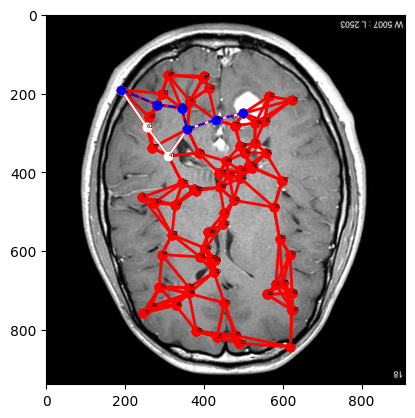

In [11]:
PRM_Algo(startNode= [190, 190], targetNode = [500, 250], image='y259.jpg', validAreas=[[ [630,230], [850,150] ]], sampleAmount=70)

Path length is: 148.01978  |  The path is: [0, 15, 1]
Path length is: 95.52487  |  The path is: [0, 1]
Path length is: 434.75849  |  The path is: [0, 15, 31, 38, 1]
Path length is: 339.20901  |  The path is: [0, 15, 31, 1]
Path length is: 1601.06855  |  The path is: [0, 25, 40, 59, 8, 30, 46, 57, 13, 61, 17, 21, 45, 28, 67, 55, 19, 36, 41, 15, 11, 37, 1]
Path length is: 679.73384  |  The path is: [0, 59, 8, 57, 13, 61, 63, 45, 16, 58, 62, 1]


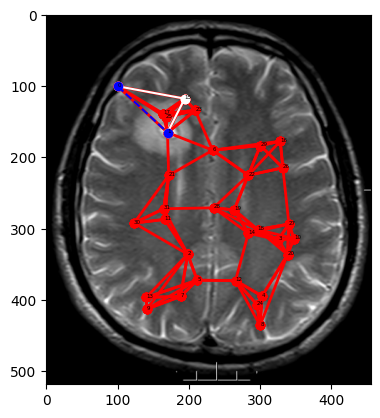

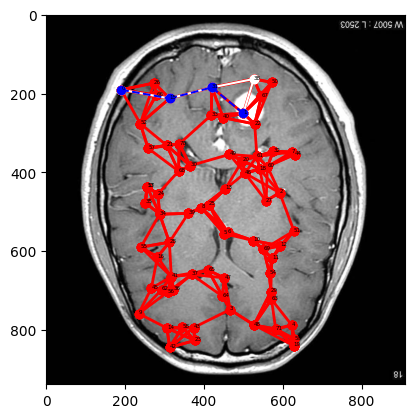

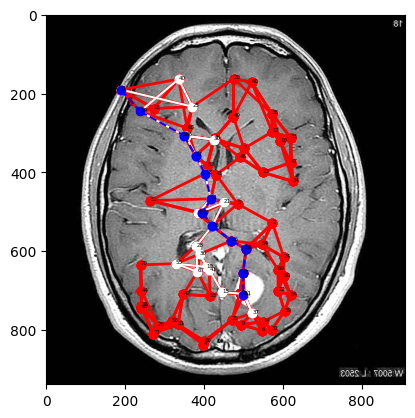

In [12]:
PRM_Algo(startNode= [100, 100], targetNode = [170, 165], image='Y3.jpg', validAreas=[[ [350,100], [450,100] ]])
PRM_Algo(startNode= [190, 190], targetNode = [500, 250], image='y259.jpg', validAreas=[[ [630,230], [850,150] ]], sampleAmount=70)
PRM_Algo(startNode= [190, 190], targetNode = [500, 710], image='y529.jpg', validAreas=[[ [630,230], [850,150] ]], sampleAmount=70)

# Step by step example:

 ~ First we generate points:

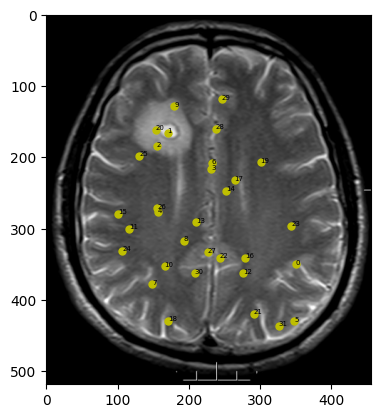

In [13]:
nodes = generatePoints_PRM(startNode= [350, 350], targetNode=[170, 165], sampleAmount= 30, validAreas=[[ [350,100], [450,100] ]])
connections: list[list[tuple[int, int]]] = []
fig, ax = plotPoints(nodes, connections, image='Y3.jpg', drawSize=5) 

~ Second we connect the points to form a graph

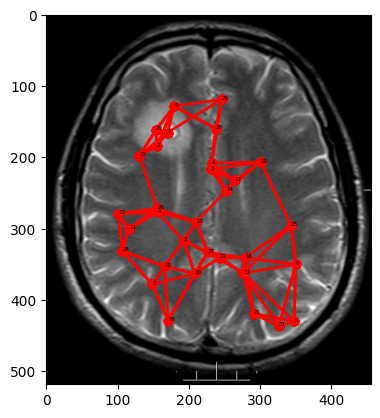

In [14]:
connections: list[list[tuple[int, int]]] = KNN_Connector(nodes, k= 4)
fig, ax = plotPoints(nodes, connections, image='Y3.jpg') 

~ Third (For comparison purpose in project) we run "stupid" dfs to find the path.

(487.5267986486236, [0, 23, 19, 3, 28, 9, 2, 25, 1])


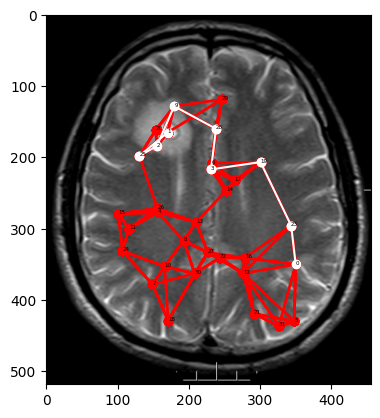

In [15]:
result = dfs(nodes, connections, start=0, finish=1)
drawPath(ax, [ nodes[x] for x in result[1] ], style='wo-')
print(result)  
fig

~ Fourth we generate the shortest path with A*

(375.6657109823038, [0, 23, 19, 6, 28, 9, 1])


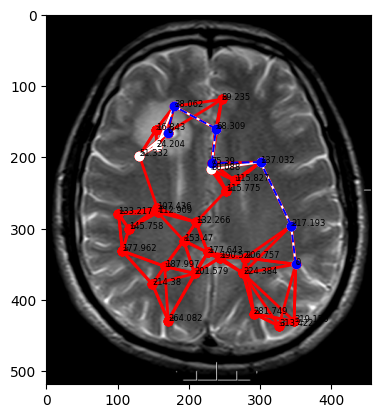

In [16]:
result = aStar(nodes, connections, start=0, finish=1)

nodes = calculateHeuristic(nodes, 0, 1)
for i, node in enumerate(nodes):
    ax.annotate(str(round(node[-1],3)), (node[0], node[1]), fontsize=6)

drawPath(ax, [ nodes[x] for x in result[1] ], style='bo--')
print(result)  
fig

# Result reached!

# Now that we have reached the result, we can extend the pipeline from either side and offer automatic segmentation and target detection (at the start) or automatic translation into a medical robot's physical actions.